# Visnir LSSM for Kex

> Ensembling Resnet, ... to predict exchangeable potassium in soil

In [ ]:
# !pip install --upgrade lssm

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import lssm
lssm.__version__

'0.1.1'

## Imports

In [ ]:
from pathlib import Path
from functools import partial
import fastcore.all as fc

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

import numpy as np

import timm
import torch
from torcheval.metrics import R2Score
from torch.optim import lr_scheduler
from torch import optim, nn

from lssm.loading import load_ossl
from lssm.preprocessing import (ToAbsorbance, ContinuumRemoval, MeanCenter, 
                                Log1p, SNV, Interpolate, wl_to_wn)
from lssm.dataloaders import SpectralDataset, get_dls
from lssm.callbacks import (MetricsCB, BatchSchedCB, BatchTransformCB,
                            DeviceCB, TrainCB, ProgressCB)
from lssm.transforms import GADFTfm, _resizeTfm, StatsTfm
from lssm.learner import Learner
from lssm.visualization import plot_spectra

## Data loading & preprocessing

In [ ]:
def stat_wn_wl(wn_wl):
    print(f'Length: {len(wn_wl)}, resolution: {wn_wl[-2]- wn_wl[-1]}, max: {np.max(wn_wl)}, min: {np.min(wn_wl)}')

In [ ]:
# K-spiking experiment data
X_nir_spik, wavenumbers_spik, names_spik = fc.load_pickle('../../_data/nir-k-spiking.pkl')

In [ ]:
stat_wn_wl(wavenumbers_spik)

Length: 949, resolution: 8, max: 11536, min: 3952


In [ ]:
%%time
analytes = 'k.ext_usda.a725_cmolc.kg'
spectra_type = 'visnir'

data = load_ossl(analytes, spectra_type)
X, y, X_names, smp_idx, ds_name, ds_label = data
X_names = wl_to_wn(X_names)

Reading & selecting data ...
CPU times: user 26.3 s, sys: 4.48 s, total: 30.8 s
Wall time: 32 s


In [ ]:
stat_wn_wl(X_names)

Length: 1051, resolution: 3.2025620496397096, max: 25000.0, min: 4000.0


In [ ]:
X = Pipeline([
    ('interpolate', Interpolate(X_names, wavenumbers_spik)),
    # ('mean center', MeanCenter()),
    ('snv', SNV())
]).fit_transform(X)

X_names = wavenumbers_spik
y = Log1p().fit_transform(y)

False


<Figure size 640x480 with 0 Axes>

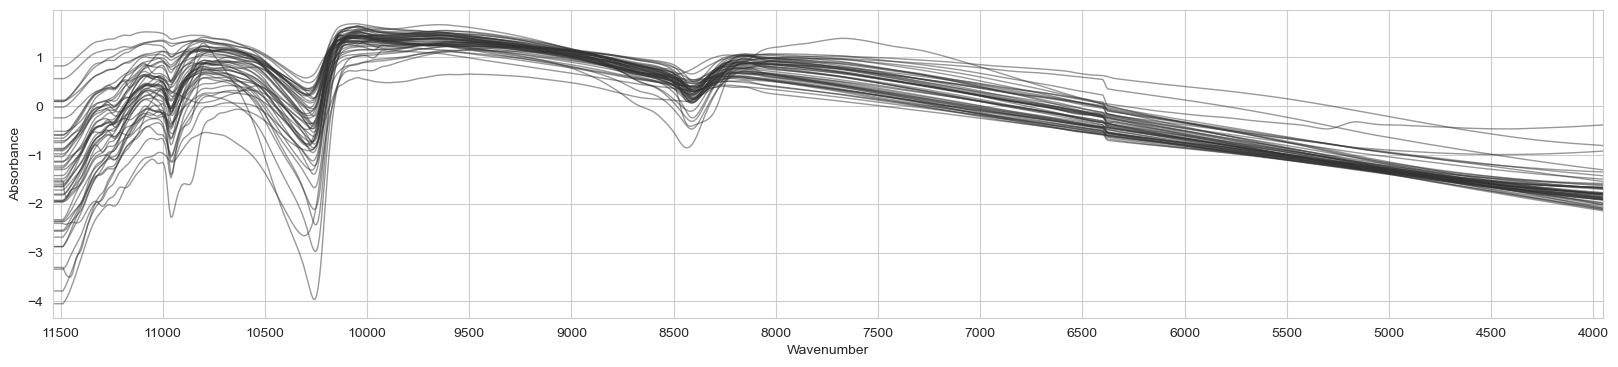

In [ ]:
plot_spectra(X_t, wavenumbers_spik, alpha=0.5, ylabel='Absorbance', ascending=False)

In [ ]:
for i, ds in enumerate(ds_label): print(f'{ds_label[i]}: {len(X[ds_name == i])}')

ICRAF.ISRIC: 3674
KSSL.SSL: 51
LUCAS.SSL: 40175
LUCAS.WOODWELL.SSL: 589


In [ ]:
# Train/valid split
n_smp = None  # For demo. purpose
X_train, X_valid, y_train, y_valid = train_test_split(X[:n_smp, :], y[:n_smp],
                                                      test_size=0.1,
                                                      stratify=ds_name[:n_smp],
                                                      random_state=41)

# Get PyTorch datasets
train_ds, valid_ds = [SpectralDataset(X, y, )
                      for X, y, in [(X_train, y_train), (X_valid, y_valid)]]

In [ ]:
X_train.shape

(40040, 949)

In [ ]:
# Then PyTorch dataloaders
dls = get_dls(train_ds, valid_ds, bs=64)

## Training

In [ ]:
def set_grad(m, b):
    if isinstance(m, (nn.Linear,nn.BatchNorm2d)): return
    if hasattr(m, 'weight'):
        for p in m.parameters(): p.requires_grad_(b) 

In [ ]:
def get_n_params(model, trainable=True):
    return sum(p.numel() for p in model.parameters() if p.requires_grad == trainable)

### Learning from scratch

In [ ]:
model_name = 'resnet18'
model = timm.create_model(model_name, pretrained=False,
                          in_chans=1, num_classes=1)

In [ ]:
# Define modelling pipeline & Train
epochs = 10
lr = 5e-4

# Define metrics
metrics = MetricsCB(r2=R2Score())

# Define scheduler (how to vary learning rate during training)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)

# Callbacks
xtra = [BatchSchedCB(sched)]
gadf = BatchTransformCB(GADFTfm())
resize = BatchTransformCB(_resizeTfm)
stats = BatchTransformCB(StatsTfm(model.default_cfg))

cbs = [DeviceCB(), gadf, resize, stats, TrainCB(),
       metrics, ProgressCB(plot=False)]

learn = Learner(model, dls, nn.HuberLoss(), lr=lr,
                cbs=cbs+xtra, opt_func=optim.AdamW)

In [ ]:
get_n_params(learn.model, trainable=True)

11170753

In [ ]:
%%time
learn.fit(epochs)

### Naive fine-tuning

In [ ]:
model_name = 'resnet18'
model = timm.create_model(model_name, pretrained=True,
                          in_chans=1, num_classes=1)

# Define modelling pipeline & Train
epochs = 5
lr = 5e-4

# Define metrics
metrics = MetricsCB(r2=R2Score())

# Define scheduler (how to vary learning rate during training)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)

# Callbacks
xtra = [BatchSchedCB(sched)]
gadf = BatchTransformCB(GADFTfm())
resize = BatchTransformCB(_resizeTfm)
stats = BatchTransformCB(StatsTfm(model.default_cfg))

cbs = [DeviceCB(), gadf, resize, stats, TrainCB(),
       metrics, ProgressCB(plot=False)]

learn = Learner(model, dls, nn.HuberLoss(), lr=lr,
                cbs=cbs+xtra, opt_func=optim.AdamW)

In [ ]:
get_n_params(learn.model, trainable=True)

11170753

In [ ]:
%%time
learn.fit(epochs)

r2,loss,epoch,train
0.455,0.038,0,train
0.439,0.040,0,eval
0.652,0.025,1,train
0.551,0.033,1,eval
0.734,0.019,2,train
0.531,0.034,2,eval
0.804,0.014,3,train
0.790,0.015,3,eval
0.860,0.010,4,train
0.804,0.014,4,eval


CPU times: user 8min 12s, sys: 2.64 s, total: 8min 15s
Wall time: 8min 12s


In [ ]:
torch.save(learn.model.state_dict(), 'resnet-pretrained-02072024-mir.pth')

#### Predicting

In [ ]:
model_name = 'resnet18'
model = timm.create_model(model_name, pretrained=True,
                          in_chans=1, num_classes=1)

fname_model = "../models/resnet-pretrained-03072024-mir-k-spiking.pth"
model.load_state_dict(torch.load(fname_model, map_location=torch.device('cpu')))

# Define modelling pipeline & Train
epochs = 1
lr = 5e-4

# Define metrics
metrics = MetricsCB(r2=R2Score())

# Define scheduler (how to vary learning rate during training)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)

# Callbacks
xtra = [BatchSchedCB(sched)]
gadf = BatchTransformCB(GADFTfm())
resize = BatchTransformCB(_resizeTfm)
stats = BatchTransformCB(StatsTfm(model.default_cfg))

cbs = [DeviceCB(device='cpu'), gadf, resize, stats, TrainCB(),
       metrics]

learn = Learner(model, dls, nn.HuberLoss(), lr=lr,
                cbs=cbs+xtra, opt_func=optim.AdamW)

In [ ]:
learn.fit(epochs)

In [ ]:
# learn.model = model

In [ ]:
# X_mir_spik, wavenumbers_spik, names_spik = fc.load_pickle('../../_data/mir-k-spiking.pkl')

In [ ]:
names_spik

array(['LUI-0-0', 'LUI-0-1', 'LUI-0-2', 'LUI-0-3', 'LUI-0-4', 'LUI-1-0',
       'LUI-1-1', 'LUI-1-2', 'LUI-1-3', 'LUI-1-4', 'LUI-2-0', 'LUI-2-1',
       'LUI-2-2', 'LUI-2-3', 'LUI-2-4', 'LUI-3-0', 'LUI-3-1', 'LUI-3-2',
       'LUI-3-3', 'LUI-3-4', 'SPA1-0-0', 'SPA1-0-2', 'SPA1-0-3',
       'SPA1-0-4', 'SPA1-1-0', 'SPA1-1-1', 'SPA1-1-2', 'SPA1-1-3',
       'SPA1-1-4', 'SPA1-2-0', 'SPA1-2-1', 'SPA1-2-2', 'SPA1-2-3',
       'SPA1-2-4', 'SPA1-3-0', 'SPA1-3-1', 'SPA1-3-2', 'SPA1-3-3',
       'SPA1-3-4', 'TM4.1-0-0', 'TM4.1-0-1', 'TM4.1-0-2', 'TM4.1-0-3',
       'TM4.1-0-4', 'TM4.1-0-5', 'TM4.1-1-0', 'TM4.1-1-1', 'TM4.1-1-2',
       'TM4.1-1-3', 'TM4.1-2-0', 'TM4.1-2-1', 'TM4.1-2-2', 'TM4.1-2-3',
       'TM4.1-3-0', 'TM4.1-3-1', 'TM4.1-3-2', 'TM4.1-3-3', 'TM4.1-3-4'],
      dtype='<U9')

In [ ]:
np.mean(np.expm1(y))

0.6474079249216373

In [ ]:
def predict(X, substring, names, learn):
    mask = [substring in name for name in names_spik]
    return learn.get_preds(X[mask], y_tfm_fn=np.expm1)

for smp_name in ['LUI', 'SPA1', 'TM4.1']:
    print(f'Sample name: {smp_name}')
    for substring in [f'{smp_name}-{i}' for i in range(4)]:
        preds = predict(X_mir_spik, substring, names_spik, learn)
        print(f'Spiking level: {substring}, mean: {np.mean(preds):.3}, std: {np.std(preds):.3}')
    print(80*'-')

Sample name: LUI
Spiking level: LUI-0, mean: 0.238, std: 0.02
Spiking level: LUI-1, mean: 0.266, std: 0.0293
Spiking level: LUI-2, mean: 0.179, std: 0.0602
Spiking level: LUI-3, mean: 0.232, std: 0.0399
--------------------------------------------------------------------------------
Sample name: SPA1
Spiking level: SPA1-0, mean: 2.26, std: 0.459
Spiking level: SPA1-1, mean: 2.29, std: 0.249
Spiking level: SPA1-2, mean: 3.16, std: 0.974
Spiking level: SPA1-3, mean: 2.88, std: 0.38
--------------------------------------------------------------------------------
Sample name: TM4.1
Spiking level: TM4.1-0, mean: 0.702, std: 0.297
Spiking level: TM4.1-1, mean: 0.329, std: 0.22
Spiking level: TM4.1-2, mean: 0.667, std: 0.0986
Spiking level: TM4.1-3, mean: 0.409, std: 0.057
--------------------------------------------------------------------------------


### Freezing batch norm & linear layers

In [ ]:
model_name = 'resnet18'
model = timm.create_model(model_name, pretrained=True,
                          in_chans=1, num_classes=1)

# Define modelling pipeline & Train
epochs = 3
lr = 5e-4

# Define metrics
metrics = MetricsCB(r2=R2Score())

# Define scheduler (how to vary learning rate during training)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)

# Callbacks
xtra = [BatchSchedCB(sched)]
gadf = BatchTransformCB(GADFTfm())
resize = BatchTransformCB(_resizeTfm)
stats = BatchTransformCB(StatsTfm(model.default_cfg))

cbs = [DeviceCB(), gadf, resize, stats, TrainCB(),
       metrics, ProgressCB(plot=False)]

learn = Learner(model, dls, nn.HuberLoss(), lr=lr,
                cbs=cbs+xtra, opt_func=optim.AdamW)

In [ ]:
learn.model.apply(partial(set_grad, b=False));

In [ ]:
get_n_params(learn.model, trainable=True)

10113

In [ ]:
%%time
learn.fit(epochs)

r2,loss,epoch,train
0.154,0.058,0,train
0.433,0.041,0,eval
0.473,0.037,1,train
0.507,0.035,1,eval
0.526,0.033,2,train
0.535,0.033,2,eval


CPU times: user 3min 40s, sys: 4.66 s, total: 3min 44s
Wall time: 3min 39s


In [ ]:
# Now unfreeze all
learn.model.apply(partial(set_grad, b=True));

In [ ]:
get_n_params(learn.model, trainable=True)

11170753

In [ ]:
%%time
learn.fit(epochs)

r2,loss,epoch,train
0.578,0.030,0,train
0.201,0.057,0,eval
0.698,0.021,1,train
0.731,0.020,1,eval
0.802,0.014,2,train
0.780,0.016,2,eval


CPU times: user 4min 43s, sys: 5.23 s, total: 4min 48s
Wall time: 4min 42s


### Learning rate finder

In [ ]:
model_name = 'resnet18'
model = timm.create_model(model_name, pretrained=False,
                          in_chans=1, num_classes=1)

In [ ]:
# Define modelling pipeline & Train
epochs = 3
lr = 5e-3

metrics = MetricsCB(r2=R2Score())

tmax = epochs * len(dls.train)

gadf = BatchTransformCB(GADFTfm())
resize = BatchTransformCB(_resizeTfm)
stats = BatchTransformCB(StatsTfm(model.default_cfg))

cbs = [DeviceCB(), gadf, resize, stats, TrainCB(),
       metrics, ProgressCB(plot=False)]

learn = Learner(model, dls, nn.HuberLoss(), lr=lr,
                cbs=cbs, opt_func=optim.AdamW)

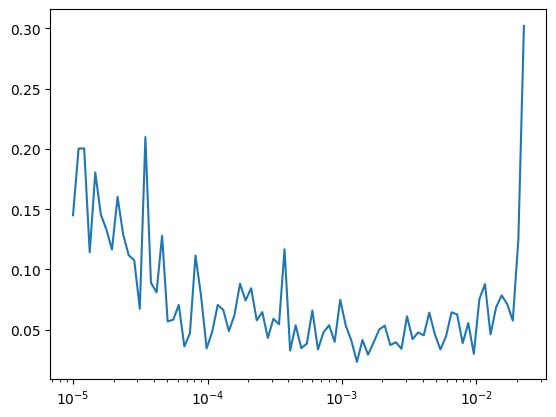

In [ ]:
# gamma=1.3, max_mult=3, start_lr=1e-5, max_epochs=10
learn.lr_find(gamma=1.1,start_lr=1e-5, max_mult=10)